# Skewed-t of Hansen (1994)

In [1]:
from scipy.special import gamma
from math import sqrt, pi
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.optimize import minimize

In [2]:
class skt:
    def cdf(z,nu,lmbda):
        c = gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
        a = 4*lmbda*c*((nu-2)/(nu-1))
        b = sqrt(1 + 3*lmbda**2 - a**2)
        
        z  = np.atleast_1d(z)
    
        f1 = z < -a/b
        f2 = z >= -a/b
    
        y1 = (b*z+a)/(1-lmbda)*sqrt(nu/(nu-2))
        y2 = (b*z+a)/(1+lmbda)*sqrt(nu/(nu-2))
    
        p1 = (1-lmbda)*t.cdf(y1, nu)
        p2 = ((1-lmbda)/2  + (1+lmbda)*(t.cdf(y2, nu)-0.5))

        p = z.copy()

        p[f1] = p1[f1]
        p[f2] = p2[f2]
        
        return(p) # cumulative probability
    
    def pdf(z,nu,lmbda):
        c = gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
        a = 4*lmbda*c*((nu-2)/(nu-1))
        b = sqrt(1 + 3*lmbda**2 - a**2)

        z  = np.atleast_1d(z)
        
        f1 = z < -a/b
        f2 = z >= -a/b

        y1 = b*c*(1 + (1/(nu-2))*((b*z+a)/(1-lmbda))**2)**-((nu+1)/2)
        y2 = b*c*(1 + (1/(nu-2))*((b*z+a)/(1+lmbda))**2)**-((nu+1)/2)

        f = z.copy()
    
        f[f1] = y1[f1]
        f[f2] = y2[f2]
        
        return(f) # density
    
    def inv(p,nu,lmbda):
        c = gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
        a = 4*lmbda*c*((nu-2)/(nu-1))
        b = sqrt(1 + 3*lmbda**2 - a**2)
  
        p  = np.atleast_1d(p)

        inv1 = ((1-lmbda)/b)*sqrt((nu-2)/nu)*t.ppf(p/(1-lmbda),nu) - a/b
        inv2 = ((1+lmbda)/b)*sqrt((nu-2)/nu)*t.ppf(0.5 + (1 / (1+lmbda))*(p-(1-lmbda)/2),nu) - a/b
        
        z = p.copy()
        
        z1 = p < (1-lmbda)/2
        z2 = p >= (1-lmbda)/2   
        
        z[z1] = inv1[z1]
        z[z2] = inv2[z2]
        return(z)
    
    def rnd(nu,lmbda,n):
        # It returns random draws from Hansen's (1994) skewed-t distribution
        u = np.random.uniform(low=0.0, high=1.0, size=(n,1))
        z = skt.inv(u,nu,lmbda)
        z = np.array(z)
        return(z)
    
    def logpdf(par,z):
        # It returns the log-likelihood at z of Hansen's (1994) skewed-t distribution
        nu = par[0]
        lmbda = par[1]
        T = z.shape[0]
        
        z  = np.atleast_1d(z)
        
        c = gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
        a = 4*lmbda*c*((nu-2)/(nu-1))
        b = sqrt(1 + 3*lmbda**2 - a**2)

        logc = np.log(gamma((nu+1)/2)) - np.log(gamma(nu/2)) - 0.5*np.log(pi*(nu-2))
        logb = 0.5*np.log(1 + 3*lmbda**2 - a**2)
        
        ll1   = logb + logc - (nu+1)/2*np.log(1+1/(nu-2)*((b*z+a)/(1-lmbda))**2)
        ll2   = logb + logc - (nu+1)/2*np.log(1+1/(nu-2)*((b*z+a)/(1+lmbda))**2)

        f1 =  z <  -a/b 
        f2 =  z >= -a/b
        
        ll = z.copy()
        
        ll = np.sum(ll1[f1]) + np.sum(ll2[f2])
        ll = -ll
        return(ll)
    
    def fit(zdata):
        # parameter restrictions:
        #  2 < nu
        # -1 < lambda < 1
        bnds = ((2.1,None),(-0.9999,0.9999))
        x0 = np.array([4, 0]) # initial guess
        solution = minimize(skt.logpdf, x0, args=(zdata), bounds=bnds)
        nu_hat = solution.x[0]
        lmbda_hat = solution.x[1]
        par = [nu_hat,lmbda_hat]
        return(par)

## Visualization

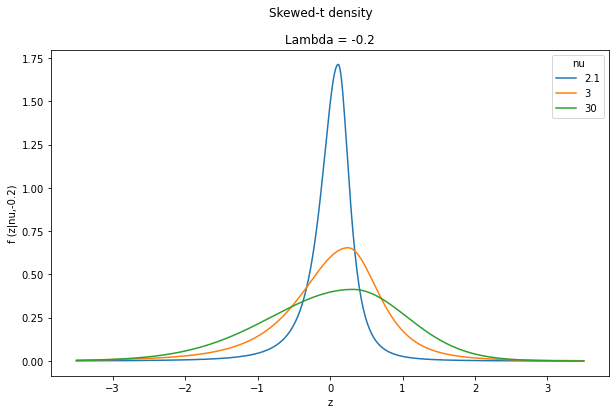

In [3]:
import matplotlib.pyplot as plt

# data
lmbda = -0.2
z = np.linspace(-3.5, 3.5, num=500)
pdf1 = skt.pdf(z,2.1,lmbda)
pdf2 = skt.pdf(z,3,lmbda)
pdf3 = skt.pdf(z,30,lmbda)

# plot lines
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(z, pdf1, label = "2.1")
plt.plot(z, pdf2, label = "3")
plt.plot(z, pdf3, label = "30")
plt.legend(title = "nu") 
plt.xlabel("z")
plt.ylabel("f (z|nu,"+str(lmbda)+")")
plt.suptitle("Skewed-t density")
plt.title("Lambda = " + str(lmbda))
plt.show()

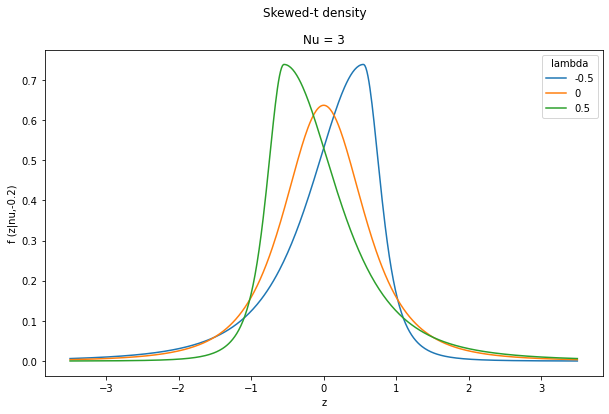

In [4]:
# data
nu = 3
z = np.linspace(-3.5, 3.5, num=500)
pdf1 = skt.pdf(z,nu,-0.5)
pdf2 = skt.pdf(z,nu,0)
pdf3 = skt.pdf(z,nu,0.5)

# plot lines
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(z, pdf1, label = "-0.5")
plt.plot(z, pdf2, label = "0")
plt.plot(z, pdf3, label = "0.5")
plt.legend(title = "lambda") 
plt.xlabel("z")
plt.ylabel("f (z|nu,"+str(lmbda)+")")
plt.suptitle("Skewed-t density")
plt.title("Nu = " + str(nu))
plt.show()

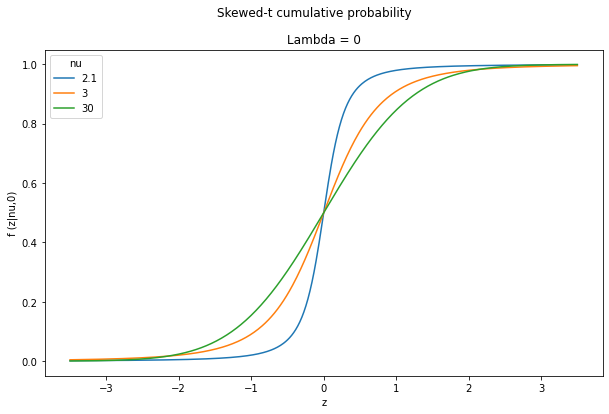

In [5]:
# data
lmbda = 0
z = np.linspace(-3.5, 3.5, num=500)
cdf1 = skt.cdf(z,2.1,lmbda)
cdf2 = skt.cdf(z,3,lmbda)
cdf3 = skt.cdf(z,30,lmbda)

# plot lines
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(z, cdf1, label = "2.1")
plt.plot(z, cdf2, label = "3")
plt.plot(z, cdf3, label = "30")
plt.legend(title = "nu") 
plt.xlabel("z")
plt.ylabel("f (z|nu,"+str(lmbda)+")")
plt.suptitle("Skewed-t cumulative probability")
plt.title("Lambda = " + str(lmbda))
plt.show()

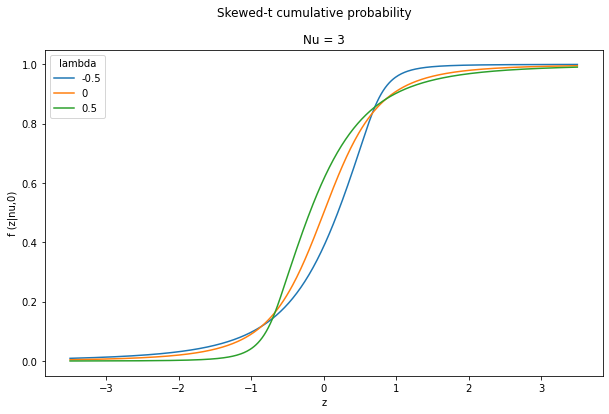

In [6]:
# data
nu = 3
z = np.linspace(-3.5, 3.5, num=500)
cdf1 = skt.cdf(z,nu,-0.5)
cdf2 = skt.cdf(z,nu,0)
cdf3 = skt.cdf(z,nu,0.5)

# plot lines
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(z, cdf1, label = "-0.5")
plt.plot(z, cdf2, label = "0")
plt.plot(z, cdf3, label = "0.5")
plt.legend(title = "lambda") 
plt.xlabel("z")
plt.ylabel("f (z|nu,"+str(lmbda)+")")
plt.suptitle("Skewed-t cumulative probability")
plt.title("Nu = " + str(nu))
plt.show()

## Simulation and Maximum Likelihood estimation

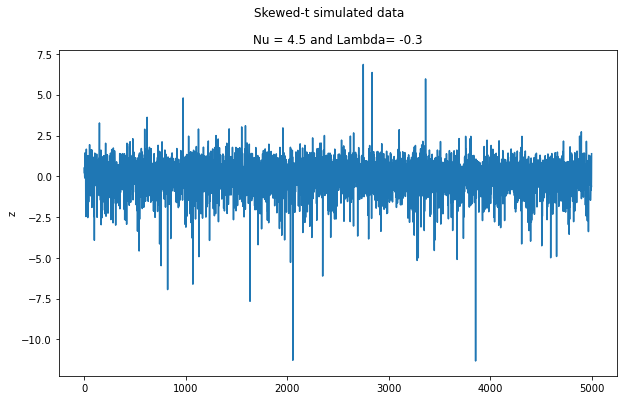

In [7]:
# Simulation
np.random.seed(0)
nu = 4.5
lmbda = -0.3
n = 5000
zdata = np.array(skt.rnd(nu,lmbda,n))

# Visualization
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.linspace(1, n, num=n), zdata)
plt.ylabel("z")
plt.suptitle("Skewed-t simulated data")
plt.title("Nu = " + str(nu) + " and Lambda= " + str(lmbda))
plt.show()

In [8]:
# ML Estimation
nu_hat, lmbda_hat = skt.fit(zdata)

pd.DataFrame([[nu, nu_hat],[lmbda,lmbda_hat]],
                  index=["nu","lambda"], columns=["True","Estimate"])

,True,Estimate
nu,4.5,4.547155
lambda,-0.3,-0.284582


## Estimation performance

In [9]:
# Estimation evaluation
N = 1000

nu = 4.5
lmbda = -0.3
n = 5000

nu_hat = np.zeros(N)
lmbda_hat = np.zeros(N)

for i in  list(range(N)):
    zdata = np.array(skt.rnd(nu,lmbda,n))
    nu_hat[i], lmbda_hat[i] = skt.fit(zdata)
       
pd.DataFrame([[nu, np.mean(nu_hat), np.std(nu_hat)],[lmbda, np.mean(lmbda_hat), np.std(lmbda_hat)]],
                  index=["nu","lambda"], columns=["True","Average Estimate","Std. Dev."])

,True,Average Estimate,Std. Dev.
nu,4.5,4.505147,0.179727
lambda,-0.3,-0.300227,0.017048


In [10]:
pardf = pd.DataFrame(np.matrix([nu_hat,lmbda_hat]).transpose(),columns=["nu_hat","lambda_hat"])
pardf.describe()

,nu_hat,lambda_hat
count,1000.000000,1000.000000
mean,4.505147,-0.300227
std,0.179817,0.017056
min,4.030396,-0.350287
25%,4.386919,-0.311773
50%,4.497099,-0.300834
75%,4.621309,-0.288583
max,5.155472,-0.242437


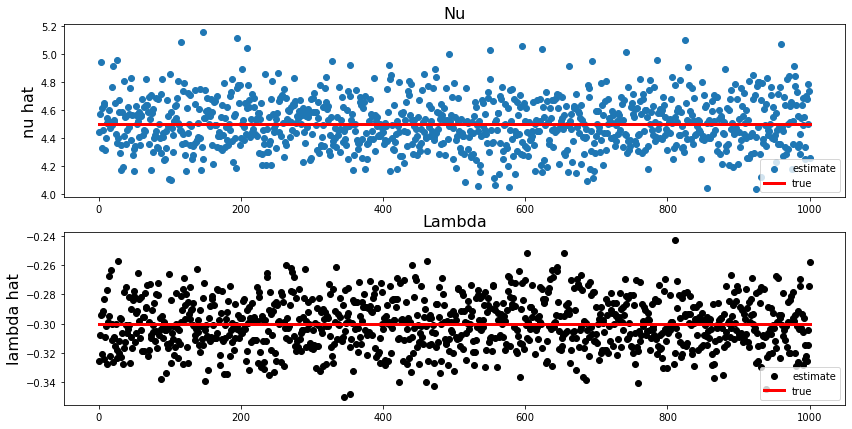

In [11]:
# Visualization
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(2, 1, 1)
plt.scatter(np.linspace(1, N, num=N), nu_hat, label="estimate")
plt.plot(np.linspace(1, N, num=N), np.repeat(nu,N), color="red", linewidth = 3, label="true")
plt.ylabel('nu hat', size = 16)
plt.title('Nu', size = 16)
legend = ax.legend(loc='lower right')

ax = fig.add_subplot(2, 1, 2)
plt.scatter(np.linspace(1, N, num=N), lmbda_hat, color="black", label="estimate")
plt.plot(np.linspace(1, N, num=N), np.repeat(lmbda,N), color="red", linewidth = 3, label="true")
plt.ylabel('lambda hat', size = 16)
plt.title('Lambda', size = 16)
legend = ax.legend(loc='lower right')

Root Mean Square Error (RMSE):

In [12]:
rmse_nu = sqrt(np.mean((nu_hat-nu)**2))
rmse_lambda = sqrt(np.mean((lmbda_hat-lmbda)**2))  

pd.DataFrame([rmse_nu,rmse_lambda],index=["nu","lambda"],columns=["RMSE"])

,RMSE
nu,0.179800
lambda,0.017049
